![logo](./img/LogoLine_horizon_C3S.png)

## Tutorial on comparing CARRA and ERA5 data 2m temperature 

CARRA and ERA5 data can be found in the CDS (Copernicus Climate Data Store, https://cds.climate.copernicus.eu/cdsapp#!/home).
The CARRA entries are at https://cds.climate.copernicus.eu/cdsapp#!/search?text=CARRA.
The complete ERA5 entry is  https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=overview.
Here the CARRA single levels are chosen for the 2m temperature (and to limit the size of the data).
You need to create an account and accept the terms and conditions for all datasets that you want to use.


### Fetching CARRA and ERA5 data
The source code will download a specific month. By specifying the start and end date below one can easily download longer periods. We are selecting 2m temperature, which is in the single level CDS entry. 
Here, we download the 3-hourly analysis time steps and the data will be stored in a specified file.
For more details on ERA5 data download please see the [CDS tutorials in this link](https://github.com/ecmwf-projects/copernicus-training-c3s)


![logo](./img/climatology_banner.png)

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>
      To run the notebooks in the cloud environment click on the icons for "binder" or "kaggle" or "colab" in the menubar below.<br><br>
      <div>
        <a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
          <img src="https://mybinder.org/badge.svg" alt="Binder">
        </a>
        <a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
          <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Kaggle">
        </a>
        <a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/reanalysis-climatology.ipynb">
          <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab">
        </a>
      </div>
    </th>
  </tr>
</table>


### Setup the CDSAPI and your credentials

*You may not need this subsection, it has been inserted here as an example of a tutorial/guide on how to access and explore data from the C3S Climate Data Store.*

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

In [45]:
import os
import cdsapi
import warnings
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
#package to interpolate ERA5 data to the CARRA grid
import xesmf as xe


warnings.filterwarnings('ignore') #turn off some warnings

### Define data request details

In [46]:
# Here one specifies the domain, year and period to download

yearStart = 2024 #first year to download
yearEnd   = 2024 #last year to download
monthStart =  3 # first month to download
monthEnd   =  3 #last month to download
days = [str(i).zfill(2) for i in range(1,31)] # the list of days to download. Adapt day number for other months
domain = 'west_domain' # the domain to select. Use "east_domain" for the East domain
period="202403" # the period to plot

#Below a polygon to limit the area downloaded from ERA5, otherwise it will download the whole world
area_for_era5 = [90, -110, 55, 40] #WEST domain polygon, format: North,West,South,East corners
#area_for_era5 = [85,0,60,50]: EAST domain polygon

### Specify data directory

In [47]:
# Directory to store data
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)
  
fCARRA = os.path.join(DATADIR,"carra_T2m_an_"+period+".grb")
fERA5 = os.path.join(DATADIR,"era5_T2m_an_"+period+".grb")

### Define helper functions to formulate the CDS data request

In [50]:
#Call the CDS client
c = cdsapi.Client(url=cdsapi_url,key=cdsapi_key)

# define a helper function to download the data
# Note that the time is hardcoded since we are selecting
# all possible available times. 
def fetch_month_carra(month, year, days, domain, fout):
    c.retrieve(
        'reanalysis-carra-single-levels',
        {
            'format': 'grib',
            'domain': domain ,
            'level_type': 'surface_or_atmosphere',
            'variable': '2m_temperature',
            'product_type': 'analysis',
            'year': year,
            'month': month,
            'day': days,
            'time': [
                '00:00', '03:00', '06:00',
                '09:00', '12:00', '15:00',
                '18:00', '21:00',
            ],
        },
        fout)
    
# Help function to download ERA5 data
def fetch_month_era5(month, year, days, area, fout):
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': str(year),
        'month': str(month).zfill(2),
        'day': days,
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': area,
        'format': 'grib',
    },
     fout)

2025-06-24 09:30:11,683 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-24 09:30:11,684 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-24 09:30:11,684 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


### Fetch the CARRA West data

In [51]:
# Loop through the period selected (in this example only 2024 03 is requested)
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(1,13)):
        if year == yearStart and month < monthStart:
            # Before the start date.
            continue
        if year == yearEnd and month > monthEnd:
            # After end date.
            break

        print ("CARRA data will be fetched for ", year, month)
        print("This will take a few minutes, depending on the data size (~621 MB for west, ~357 MB for east case)")
        fetch_month_carra(month, year, days, domain,fCARRA)

CARRA data will be fetched for  2024 3
This will take a few minutes, depending on the data size (~621 MB for west, ~357 MB for east case)


2025-06-24 09:30:14,151 INFO Request ID is ba68eac5-6b8d-4f0a-a14d-e1c30531cdb0
2025-06-24 09:30:14,198 INFO status has been updated to accepted
2025-06-24 09:30:35,490 INFO status has been updated to successful


1fd4a33406b190feda1ce0bc5eabd2ee.grib:   0%|          | 0.00/621M [00:00<?, ?B/s]

### Fetch the ERA5 data

In [52]:
# Loop through the period selected
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(1,13)):
        if year == yearStart and month < monthStart:
            # Before the start date.
            continue
        if year == yearEnd and month > monthEnd:
            # After end date.
            break

        print ("ERA5 data will be fetched for ", year, month)
        print("This will take a few minutes, depending on the data size (~39 MB for west area)")
        fetch_month_era5(month, year, days, area_for_era5,fERA5)

ERA5 data will be fetched for  2024 3
This will take a few minutes, depending on the data size (~39 MB for west area)


2025-06-24 09:30:39,157 INFO Request ID is f259de58-96f1-456c-93f1-b94b74ee43da
2025-06-24 09:30:39,197 INFO status has been updated to accepted
2025-06-24 09:30:47,552 INFO status has been updated to running
2025-06-24 09:30:52,664 INFO status has been updated to successful


94037f2ad95e2d6daa46cb807bc67976.grib:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

# Plotting the CARRA and ERA5 data

## Interpolate data to a common grid
Before plotting the two data sets we need to have them first in the same grid.
We use the [CDO library](https://code.mpimet.mpg.de/projects/cdo/wiki) to interpolate the ERA5 data
into the CARRA West grid for a fair comparison. 
After importing the CDOs into python it is one line to interpolate between the grids.
Note that CDO can handle both GRIB format and NetCDF data. For instance, CARRA is downloaded in GRIB whereas we downloaded ERA5 as NetCDF.

More information regarding the CDOs (Climate data operators) can be found at https://code.mpimet.mpg.de/projects/cdo

The interpolation/projection can also be done using the [pyresample](https://pyresample.readthedocs.io/en/latest/howtos/swath.html) library.

In [53]:
ERA5  = xr.open_dataset(fERA5)
ERA5

<xarray.Dataset> Size: 81MB
Dimensions:     (time: 240, latitude: 141, longitude: 601)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 2kB 2024-03-01 ... 2024-03-30T21:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 90.0 89.75 89.5 89.25 ... 55.5 55.25 55.0
  * longitude   (longitude) float64 5kB -110.0 -109.8 -109.5 ... 39.5 39.75 40.0
    valid_time  (time) datetime64[ns] 2kB ...
Data variables:
    t2m         (time, latitude, longitude) float32 81MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-24T09:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [54]:
CARRA  = xr.open_dataset(fCARRA)
CARRA

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 240, y: 1269, x: 1069)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2024-03-01 ... 2024-03-30T21...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 11MB ...
    longitude          (y, x) float64 11MB ...
    valid_time         (time) datetime64[ns] 2kB ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (time, y, x) float32 1GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2025-06-24T09:31 GRIB to CDM+CF via cfgrib-0.9.1...

We remove some additional coordinates in the datasets.

In [55]:
ERA5 = ERA5.drop_vars(['number', 'step', 'valid_time', 'surface'])
CARRA = CARRA.drop_vars(['step', 'valid_time', 'heightAboveGround'])

In [59]:
# Create regridder using xesmf bilinear interpolation
regridder = xe.Regridder(ERA5, CARRA, "bilinear")
# Regrid the data
print("regridding the ERA5 data")
ERA5_CARRA = regridder(ERA5)
print("done")

regridding the ERA5 data
done


Check the format of the output and save it.

In [62]:
ERA5_CARRA
fERA5_CARRA_grid = os.path.join(DATADIR,"era5_t2m_"+period+"_CARRA_grid.nc")
ERA5_CARRA.to_netcdf(fERA5_CARRA_grid)

## Plotting the data
Compute the mean 2m temperature over the whole month.
First we open the data sets using xarray and then calculate the mean over the whole month.


In [63]:
# Open the data sets to plot using xarray

import xarray as xr

# Open Datasets
CARRA = xr.open_dataset(fCARRA)
CARRA = CARRA.drop_vars(['step', 'valid_time', 'heightAboveGround'])
ERA5  = xr.open_dataset(fERA5_CARRA_grid)
print(CARRA.time.values)
print(ERA5.time.values)

# Compute monthly mean
print("Computing the mean for CARRA and ERA5...")
CARRA_mean = CARRA.mean("time", keep_attrs=True)
ERA5_mean = ERA5.mean("time", keep_attrs=True)
print("Done.")

# Change longitudes from 0-360 to -180 to 180, needed for the plotting
CARRA_mean = CARRA_mean.assign_coords(longitude=(((CARRA_mean.longitude + 180) % 360) - 180))
ERA5_mean = ERA5_mean.assign_coords(longitude=CARRA_mean.longitude)

# Change unit from K to C and add the unit to the attributes
CARRA_mean_C = CARRA_mean - 273.15
CARRA_mean_C = CARRA_mean_C.assign_attrs(CARRA_mean.attrs)
CARRA_mean_C.attrs['units'] = 'deg C'
ERA5_mean_C = ERA5_mean - 273.15
ERA5_mean_C = ERA5_mean_C.assign_attrs(ERA5_mean.attrs)
ERA5_mean_C.attrs['units'] = 'deg C'

['2024-03-01T00:00:00.000000000' '2024-03-01T03:00:00.000000000'
 '2024-03-01T06:00:00.000000000' '2024-03-01T09:00:00.000000000'
 '2024-03-01T12:00:00.000000000' '2024-03-01T15:00:00.000000000'
 '2024-03-01T18:00:00.000000000' '2024-03-01T21:00:00.000000000'
 '2024-03-02T00:00:00.000000000' '2024-03-02T03:00:00.000000000'
 '2024-03-02T06:00:00.000000000' '2024-03-02T09:00:00.000000000'
 '2024-03-02T12:00:00.000000000' '2024-03-02T15:00:00.000000000'
 '2024-03-02T18:00:00.000000000' '2024-03-02T21:00:00.000000000'
 '2024-03-03T00:00:00.000000000' '2024-03-03T03:00:00.000000000'
 '2024-03-03T06:00:00.000000000' '2024-03-03T09:00:00.000000000'
 '2024-03-03T12:00:00.000000000' '2024-03-03T15:00:00.000000000'
 '2024-03-03T18:00:00.000000000' '2024-03-03T21:00:00.000000000'
 '2024-03-04T00:00:00.000000000' '2024-03-04T03:00:00.000000000'
 '2024-03-04T06:00:00.000000000' '2024-03-04T09:00:00.000000000'
 '2024-03-04T12:00:00.000000000' '2024-03-04T15:00:00.000000000'
 '2024-03-04T18:00:00.000

### Plot for CARRA

Plotting CARRA mean surface temperature


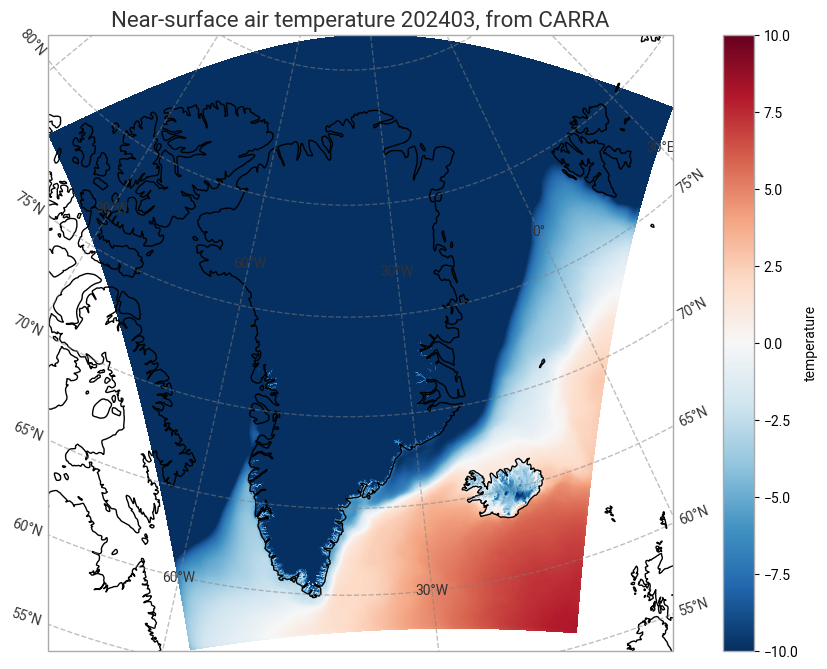

In [64]:
print("Plotting CARRA mean surface temperature")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(CARRA_mean_C.longitude, CARRA_mean_C.latitude,CARRA_mean_C.t2m,
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-10, vmax=10)

# Set the figure title
ax.set_title('Near-surface air temperature '+period+', from CARRA', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

### Plot for ERA5

Plotting ERA5 mean surface temperature


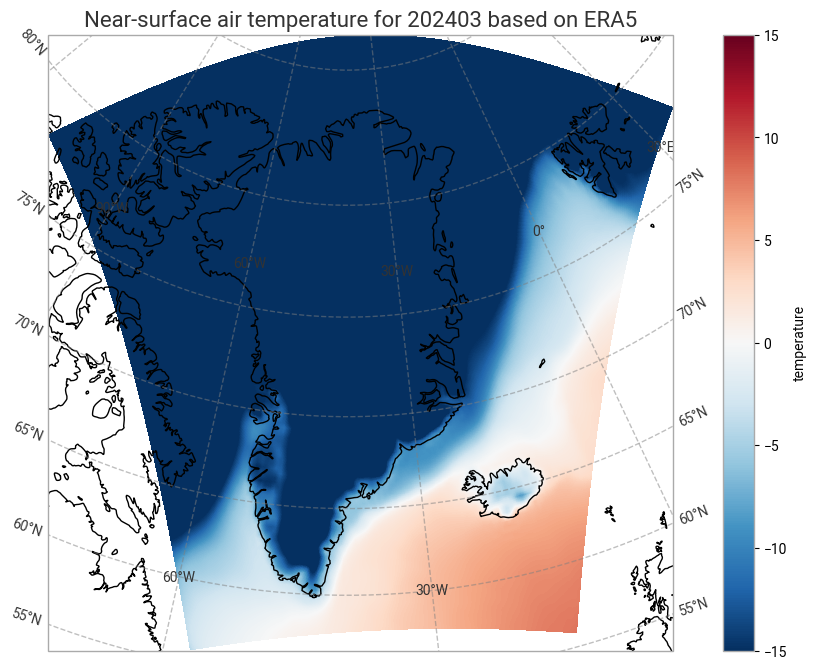

In [65]:

print("Plotting ERA5 mean surface temperature")

# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_mean_C.longitude, ERA5_mean_C.latitude, ERA5_mean_C.t2m, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-15, vmax=15)

# Set the figure title
ax.set_title('Near-surface air temperature for '+period+' based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')

### Plot the difference between CARRA and ERA5
Note that the differences are computed in the plotting command itself.

Plot the difference CARRA - ERA5


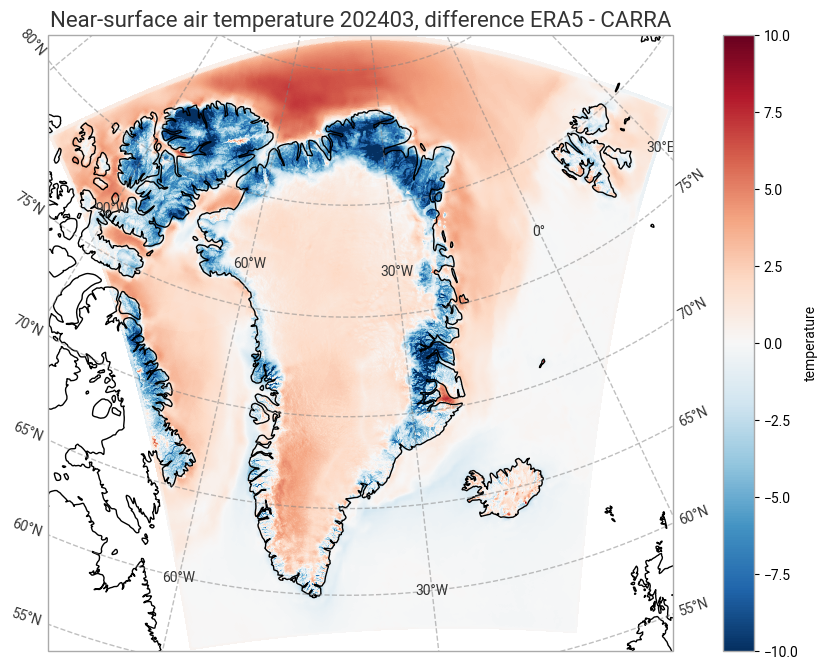

In [66]:
print("Plot the difference CARRA - ERA5")
# create the figure panel and the map using the Cartopy Lambert conformal projection
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data, the differences are computed directly in the line below.
im = plt.pcolormesh(CARRA_mean_C.longitude, CARRA_mean_C.latitude, ERA5_mean_C.t2m - CARRA_mean_C.t2m,
                    transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-10, vmax=10)

# Set the figure title
ax.set_title('Near-surface air temperature '+period+', difference ERA5 - CARRA', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('temperature')